<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0/blob/master/06_NormalizationRegularization/06_NormalizationRegularization_Modularized_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalization & Regularization

## Layer Added Model

- Convolution Block 1
    - `Conv2D:  1, 14, 3; Out: 26x26x14`
    - `Conv2D: 14, 30, 3; Out: 24x24x30`

- Transition Block
    - `Conv2D: 30, 10, 1; Out: 24x24x10`
    - `MaxPool2D: 2x2;    Out: 12x12x10`

- Convolution Block 2
    - `Conv2D: 10, 14, 3; Out: 10x10x14`
    - `Conv2D: 14, 15, 3; Out: 8x8x15`
    - `Conv2D: 15, 15, 3; Out: 6x6x15`

- GAP
    - `AvgPool2D: 6x6;    Out: 1x1x15`
    - `Conv2D: 15, 15, 1; Out: 1x1x15`
    - `Conv2D: 15, 10, 1; Out: 1x1x10`


Legend
- `Conv2D (input_channels), (output_channels), (kernel_size); Out: (output_dim)`
- `MaxPool2D: (kernel_size); Out: (output_dim)`
- `AvgPool2D: (kernel_size); Out: (output_dim)`

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# note about pin_memory
# If you load your samples in the Dataset on CPU and would like to push it
# during training to the GPU, you can speed up the host to device transfer by
# enabling pin_memory. This lets your DataLoader allocate the samples in
# page-locked memory, which speeds-up the transfer.

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, dropout_value = 0.08):

        self.dropout_value = dropout_value # dropout value

        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),            
            nn.Dropout(self.dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU(),            
            nn.Dropout(self.dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU(),            
            nn.Dropout(self.dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(self.dropout_value)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(self.dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
       BatchNorm2d-2           [-1, 14, 26, 26]              28
              ReLU-3           [-1, 14, 26, 26]               0
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 30, 24, 24]           3,780
       BatchNorm2d-6           [-1, 30, 24, 24]              60
              ReLU-7           [-1, 30, 24, 24]               0
           Dropout-8           [-1, 30, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             300
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
      BatchNorm2d-12           [-1, 14, 10, 10]              28
             ReLU-13           [-1, 14, 10, 10]               0
          Dropout-14           [-1

# Training and Testing

Define the Trainer Class that contains the train loop and test functions

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Trainer():
    """Trainer Class
    """

    def __init__(self, model, optimizer, train_loader, test_loader,
                 lr_scheduler=None, use_cuda=True):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = torch.device('cuda' if use_cuda else 'cpu')
        self.lr_scheduler = lr_scheduler

    def train(self, n_epoch=5, l1_lambda=0, l2_lambda=0, loss_func='nll'):
        """train
        Trains the model for n_epoch number of times
        """

        # set the loss function
        if loss_func == 'mse':
            self.loss_func = nn.MSELoss
        elif loss_func == 'nll':
            self.loss_func = F.nll_loss

        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # set the l2 lambda in the optimizer
        # for param_group in self.optimizer.param_groups:
        #     param_group['weight_decay'] = self.l2_lambda
        
        train_losses = []
        test_losses  = []
        train_acc    = []
        test_acc     = []
        lr_values    = []

        print('Training the model for {} epochs'.format(n_epoch))

        for epoch in range(1, n_epoch+1):
            # store the current LR value
            if self.lr_scheduler is not None:
                lr_values.append(self.lr_scheduler)
                print('EPOCH:', epoch, 'LR:', self.lr_scheduler.get_lr())
            else:
                print('EPOCH:', epoch)

            # train the model
            c_train_acc, c_train_loss = self._train_epoch(epoch)

            # validate the model
            c_test_acc, c_test_loss = self.test()

            train_acc.extend(c_train_acc)
            train_losses.extend(c_train_loss)
            test_acc.extend(c_test_acc)
            test_losses.extend(c_test_loss)
        
        return ((train_acc, train_losses), (test_acc, test_losses) , lr_values)

    def _train_epoch(self, epoch):
        # this automatically selects tqdm for colab_notebook
        from tqdm.auto import tqdm, trange

        """train_epoch
        Training logic for an epoch

        :param epoch: Integer, current epoch number
        :return: a log that contains the train_accuracy, train_loss, lr_values
        """

        train_acc  = []
        train_loss = []
        lr_values  = []

        correct = 0
        processed = 0

        self.model.train()

        pbar = tqdm(self.train_loader, ncols="80%")

        for batch_idx, (data, target) in enumerate(pbar):

            data, target = data.to(self.device), target.to(self.device) # get samples

            self.optimizer.zero_grad() # init

            # Predict
            y_pred = self.model(data)

            # Calculate loss
            criterion = self.loss_func(y_pred, target)

            if self.l1_lambda > 0:
                # l1 regularization
                l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

                loss = criterion + self.l2_lambda * l1_reg_loss
            else:
                loss = criterion

            train_loss.append(loss.data.cpu().numpy().item())

            # Backpropagation
            loss.backward()
            self.optimizer.step()

            # Update the Learning Rate
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            
            # get the index of the max log-probability
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            # Update pbar-tqdm
            pbar.set_description(desc= f'epoch={epoch} loss={loss.item()} batch_id={batch_idx} accuracy={100*correct/processed:0.2f}')
            train_acc.append(100*correct/processed)

        return (train_acc, train_loss)

    def test(self):
        test_losses = []
        test_acc    = []

        # set the model in evaluation mode
        self.model.eval()

        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                # sum up batch loss
                test_loss += self.loss_func(output, target, reduction='sum').item()
                # get the index of the max log-probability
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.dataset)
        test_losses.append(test_loss)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(self.test_loader.dataset),
            100. * correct / len(self.test_loader.dataset)))
        
        test_acc.append(100. * correct / len(self.test_loader.dataset))

        return (test_acc, test_losses)

    def get_misclassified(self):
        misclassified = []
        misclassified_pred = []
        misclassified_target = []
        # put the model to evaluation mode
        self.model.eval()
        # turn off gradients
        with torch.no_grad():
            for data, target in self.test_loader:
                # move them to the respective device
                data, target = data.to(self.device), target.to(self.device)
                # do inferencing
                output = self.model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_pred = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]

                # batch_misclassified =

                misclassified.append(batch_misclassified)
                misclassified_pred.append(batch_mis_pred)
                misclassified_target.append(batch_mis_target)

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_pred)
        misclassified_target = torch.cat(misclassified_target)

        return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

# Functions for Plotting the Progress and Misclassified Images

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

def plot_metrics(train_metric, test_metric):
    (train_acc, train_losses) = train_metric
    (test_acc, test_losses) = test_metric

    fig, axs = plt.subplots(2,2,figsize=(14,10))
    fig.suptitle('Metrics')
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")
    plt.show()

def plot_misclassification(misclassified):
    print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(12, 14))
    fig.suptitle('Misclassifications')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        ax.imshow(image.squeeze())
    plt.show()

# Perform various tests on L1 and L2 Regularization

In [0]:
import copy # to perform a deep copy of the model
from torch.optim.lr_scheduler import OneCycleLR

# for saving the metrics and models into a dictionary
metric_values = {}
models = {}

EPOCHS = 40

# Without L1/L2

In [10]:
experiment_name = 'nol1_nol2'

# move the model to device
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# create our Trainer object
trainer = Trainer(model, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)

# train and test the model
train_metric, test_metric, lr_values = trainer.train(n_epoch=EPOCHS, l1_lambda=0, l2_lambda=0)

# save the metrics
metric_values[experiment_name] = copy.deepcopy((train_metric, test_metric))

# save the model
models[experiment_name] = copy.deepcopy(model)

torch.save(model, './{}'.format(experiment_name))

Training the model for 40 epochs
EPOCH: 1 LR: [0.0003999999999999993]




Test set: Average loss: 0.6663, Accuracy: 8702/10000 (87.02%)

EPOCH: 2 LR: [0.000563613839009016]




Test set: Average loss: 0.2509, Accuracy: 9396/10000 (93.96%)

EPOCH: 3 LR: [0.0010433014025713703]




Test set: Average loss: 0.1161, Accuracy: 9685/10000 (96.85%)

EPOCH: 4 LR: [0.0018063612224373474]




Test set: Average loss: 0.0739, Accuracy: 9788/10000 (97.88%)

EPOCH: 5 LR: [0.0028007736542228637]




Test set: Average loss: 0.0731, Accuracy: 9773/10000 (97.73%)

EPOCH: 6 LR: [0.003958747183126785]




Test set: Average loss: 0.0394, Accuracy: 9886/10000 (98.86%)

EPOCH: 7 LR: [0.005201339936426282]




Test set: Average loss: 0.0375, Accuracy: 9887/10000 (98.87%)

EPOCH: 8 LR: [0.0064438413429996405]




Test set: Average loss: 0.0379, Accuracy: 9884/10000 (98.84%)

EPOCH: 9 LR: [0.007601547059053706]




Test set: Average loss: 0.0372, Accuracy: 9890/10000 (98.90%)

EPOCH: 10 LR: [0.008595533469319192]




Test set: Average loss: 0.0317, Accuracy: 9906/10000 (99.06%)

EPOCH: 11 LR: [0.009358038101918462]




Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 12 LR: [0.009837079160934131]




Test set: Average loss: 0.0275, Accuracy: 9915/10000 (99.15%)

EPOCH: 13 LR: [0.009999999856920877]




Test set: Average loss: 0.0294, Accuracy: 9902/10000 (99.02%)

EPOCH: 14 LR: [0.009968427106235795]




Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 15 LR: [0.009874373753452848]




Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 16 LR: [0.009719022574054307]




Test set: Average loss: 0.0251, Accuracy: 9914/10000 (99.14%)

EPOCH: 17 LR: [0.00950432719925796]




Test set: Average loss: 0.0285, Accuracy: 9902/10000 (99.02%)

EPOCH: 18 LR: [0.009232987547971035]




Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 19 LR: [0.008908415873743395]




Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 20 LR: [0.008534693853699324]




Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 21 LR: [0.008116521259079443]




Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 22 LR: [0.00765915685289049]




Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 23 LR: [0.0071683522579092974]




Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 24 LR: [0.006650279626689217]




Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 25 LR: [0.00611145402316058]




Test set: Average loss: 0.0232, Accuracy: 9920/10000 (99.20%)

EPOCH: 26 LR: [0.0055586514919216574]




Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 27 LR: [0.004998823845546279]




Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 28 LR: [0.004439011241507181]




Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 29 LR: [0.0038862536481109942]




Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 30 LR: [0.003347502312812102]




Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 31 LR: [0.0028295323462426913]




Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)

EPOCH: 32 LR: [0.0023388575212655504]




Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

EPOCH: 33 LR: [0.00188164835850093]




Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 34 LR: [0.0014636545284495313]




Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 35 LR: [0.0010901325460499196]




Test set: Average loss: 0.0171, Accuracy: 9942/10000 (99.42%)

EPOCH: 36 LR: [0.0007657796669532728]




Test set: Average loss: 0.0163, Accuracy: 9947/10000 (99.47%)

EPOCH: 37 LR: [0.0004946748168081546]




Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 38 LR: [0.00028022729640383835]




Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 39 LR: [0.0001251339077347576]




Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 40 LR: [3.1345040150706035e-05]




Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Plot Metrics

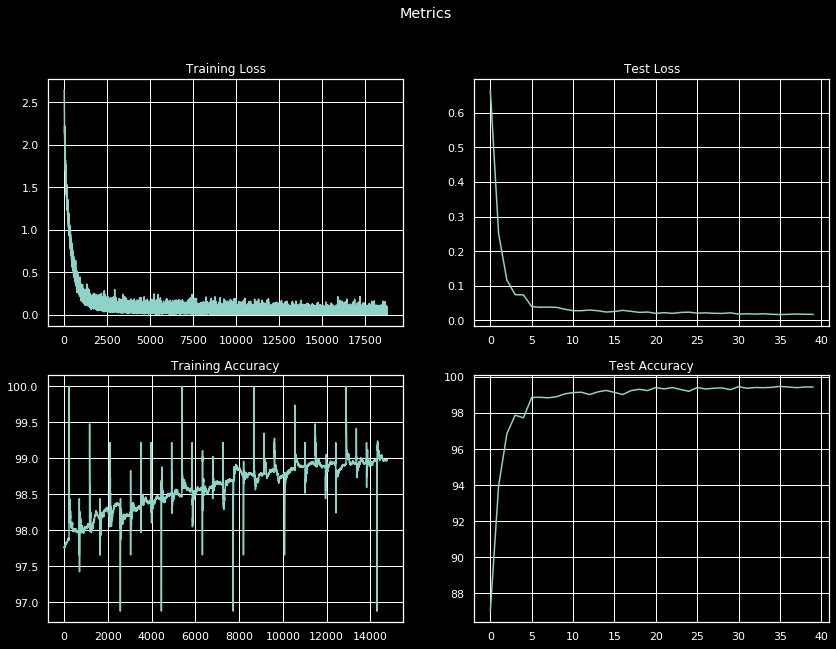

In [11]:
plot_metrics(train_metric, test_metric)

## Plot Misclassifications

Total Misclassifications : 56


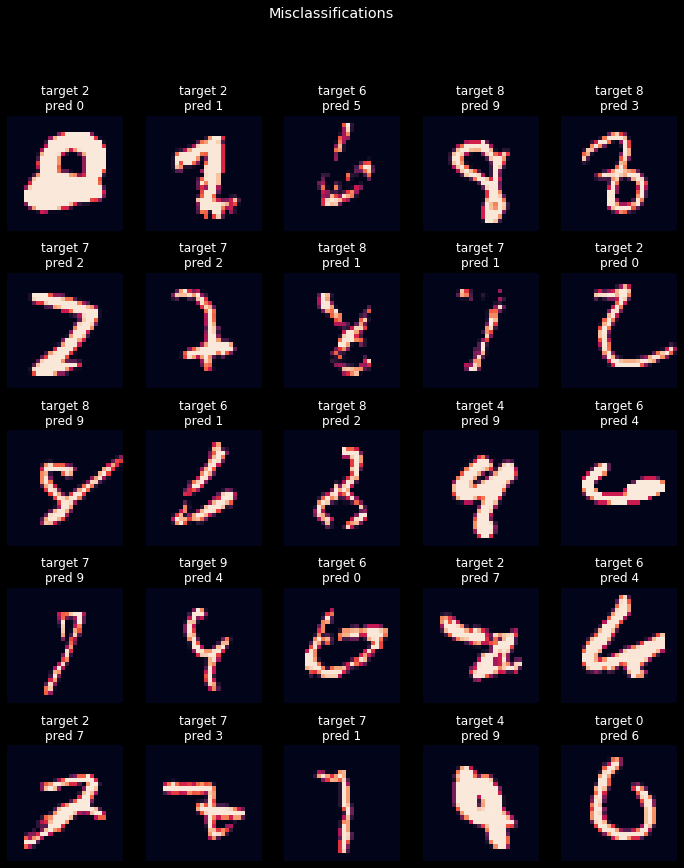

In [12]:
misclassified = trainer.get_misclassified()
plot_misclassification(misclassified)

# With only L1

In [13]:
experiment_name = 'l1'

# move the model to device
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# create our Trainer object
trainer = Trainer(model, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)

# train and test the model
train_metric, test_metric, lr_values = trainer.train(n_epoch=EPOCHS, l1_lambda=5e-4, l2_lambda=0)

# save the metrics
metric_values[experiment_name] = copy.deepcopy((train_metric, test_metric))

# save the model
models[experiment_name] = copy.deepcopy(model)

torch.save(model, './{}'.format(experiment_name))

Training the model for 40 epochs
EPOCH: 1 LR: [0.0003999999999999993]




Test set: Average loss: 0.8961, Accuracy: 7984/10000 (79.84%)

EPOCH: 2 LR: [0.000563613839009016]




Test set: Average loss: 0.2941, Accuracy: 9358/10000 (93.58%)

EPOCH: 3 LR: [0.0010433014025713703]




Test set: Average loss: 0.1458, Accuracy: 9620/10000 (96.20%)

EPOCH: 4 LR: [0.0018063612224373474]




Test set: Average loss: 0.0688, Accuracy: 9813/10000 (98.13%)

EPOCH: 5 LR: [0.0028007736542228637]




Test set: Average loss: 0.0584, Accuracy: 9841/10000 (98.41%)

EPOCH: 6 LR: [0.003958747183126785]




Test set: Average loss: 0.0693, Accuracy: 9785/10000 (97.85%)

EPOCH: 7 LR: [0.005201339936426282]




Test set: Average loss: 0.0502, Accuracy: 9865/10000 (98.65%)

EPOCH: 8 LR: [0.0064438413429996405]




Test set: Average loss: 0.0429, Accuracy: 9873/10000 (98.73%)

EPOCH: 9 LR: [0.007601547059053706]




Test set: Average loss: 0.0370, Accuracy: 9891/10000 (98.91%)

EPOCH: 10 LR: [0.008595533469319192]




Test set: Average loss: 0.0366, Accuracy: 9879/10000 (98.79%)

EPOCH: 11 LR: [0.009358038101918462]




Test set: Average loss: 0.0344, Accuracy: 9889/10000 (98.89%)

EPOCH: 12 LR: [0.009837079160934131]




Test set: Average loss: 0.0372, Accuracy: 9883/10000 (98.83%)

EPOCH: 13 LR: [0.009999999856920877]




Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 14 LR: [0.009968427106235795]




Test set: Average loss: 0.0218, Accuracy: 9926/10000 (99.26%)

EPOCH: 15 LR: [0.009874373753452848]




Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 16 LR: [0.009719022574054307]




Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH: 17 LR: [0.00950432719925796]




Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)

EPOCH: 18 LR: [0.009232987547971035]




Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 19 LR: [0.008908415873743395]




Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 20 LR: [0.008534693853699324]




Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 21 LR: [0.008116521259079443]




Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)

EPOCH: 22 LR: [0.00765915685289049]




Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 23 LR: [0.0071683522579092974]




Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 24 LR: [0.006650279626689217]




Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 25 LR: [0.00611145402316058]




Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 26 LR: [0.0055586514919216574]




Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 27 LR: [0.004998823845546279]




Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 28 LR: [0.004439011241507181]




Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

EPOCH: 29 LR: [0.0038862536481109942]




Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 30 LR: [0.003347502312812102]




Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 31 LR: [0.0028295323462426913]




Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 32 LR: [0.0023388575212655504]




Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)

EPOCH: 33 LR: [0.00188164835850093]




Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 34 LR: [0.0014636545284495313]




Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 35 LR: [0.0010901325460499196]




Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 36 LR: [0.0007657796669532728]




Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 37 LR: [0.0004946748168081546]




Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 38 LR: [0.00028022729640383835]




Test set: Average loss: 0.0182, Accuracy: 9936/10000 (99.36%)

EPOCH: 39 LR: [0.0001251339077347576]




Test set: Average loss: 0.0179, Accuracy: 9937/10000 (99.37%)

EPOCH: 40 LR: [3.1345040150706035e-05]




Test set: Average loss: 0.0181, Accuracy: 9938/10000 (99.38%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Plot Metrics

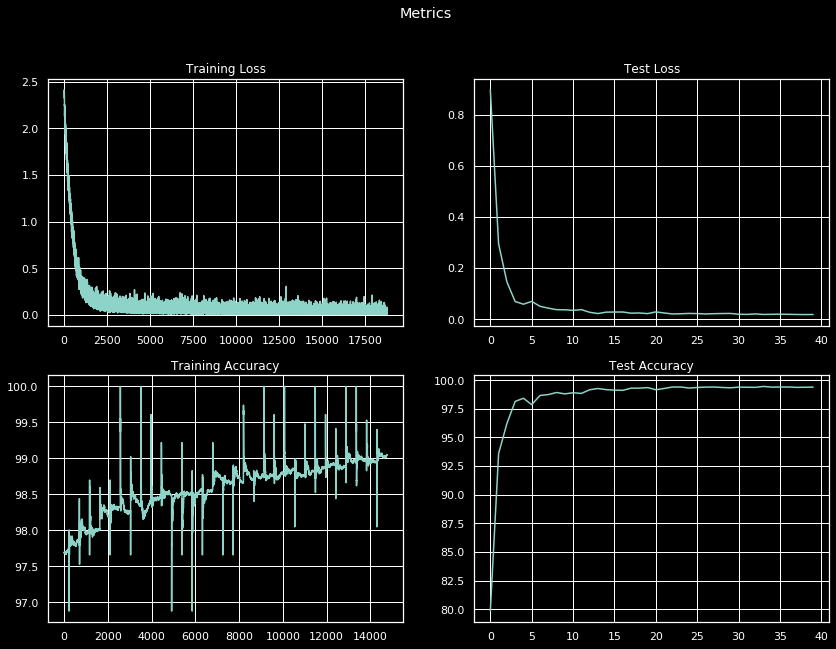

In [14]:
plot_metrics(train_metric, test_metric)

## Plot Misclassifications

Total Misclassifications : 62


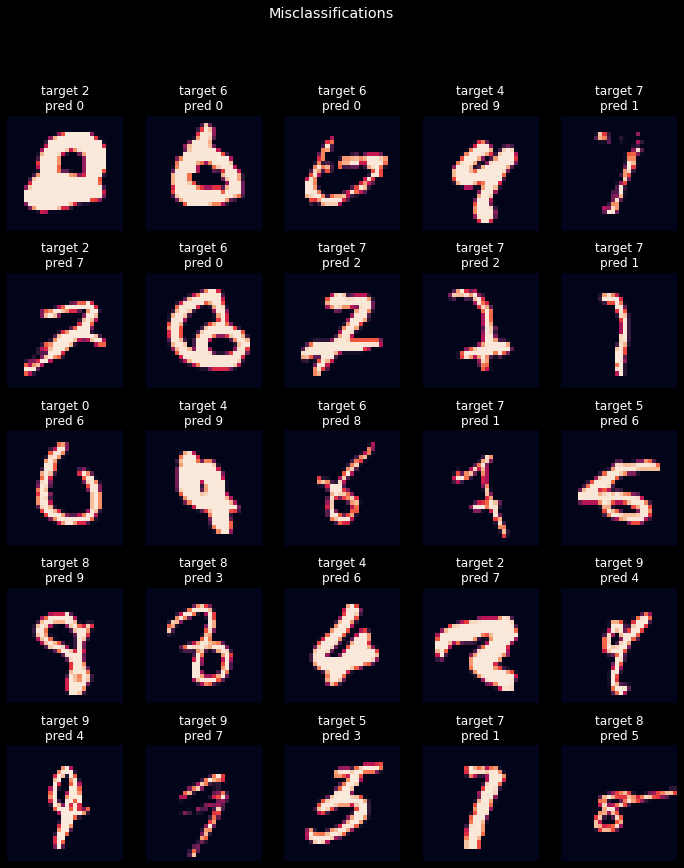

In [15]:
misclassified = trainer.get_misclassified()
plot_misclassification(misclassified)

# With only L2

In [16]:
experiment_name = 'l2'

# move the model to device
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=5e-3)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# create our Trainer object
trainer = Trainer(model, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)

# train and test the model
train_metric, test_metric, lr_values = trainer.train(n_epoch=EPOCHS, l1_lambda=0, l2_lambda=5e-3)

# save the metrics
metric_values[experiment_name] = copy.deepcopy((train_metric, test_metric))

# save the model
models[experiment_name] = copy.deepcopy(model)

torch.save(model, './{}'.format(experiment_name))

Training the model for 40 epochs
EPOCH: 1 LR: [0.0003999999999999993]




Test set: Average loss: 0.7335, Accuracy: 8714/10000 (87.14%)

EPOCH: 2 LR: [0.000563613839009016]




Test set: Average loss: 0.2231, Accuracy: 9593/10000 (95.93%)

EPOCH: 3 LR: [0.0010433014025713703]




Test set: Average loss: 0.1024, Accuracy: 9783/10000 (97.83%)

EPOCH: 4 LR: [0.0018063612224373474]




Test set: Average loss: 0.0985, Accuracy: 9761/10000 (97.61%)

EPOCH: 5 LR: [0.0028007736542228637]




Test set: Average loss: 0.0557, Accuracy: 9876/10000 (98.76%)

EPOCH: 6 LR: [0.003958747183126785]




Test set: Average loss: 0.0518, Accuracy: 9872/10000 (98.72%)

EPOCH: 7 LR: [0.005201339936426282]




Test set: Average loss: 0.0470, Accuracy: 9896/10000 (98.96%)

EPOCH: 8 LR: [0.0064438413429996405]




Test set: Average loss: 0.0469, Accuracy: 9892/10000 (98.92%)

EPOCH: 9 LR: [0.007601547059053706]




Test set: Average loss: 0.0570, Accuracy: 9867/10000 (98.67%)

EPOCH: 10 LR: [0.008595533469319192]




Test set: Average loss: 0.0496, Accuracy: 9876/10000 (98.76%)

EPOCH: 11 LR: [0.009358038101918462]




Test set: Average loss: 0.0591, Accuracy: 9846/10000 (98.46%)

EPOCH: 12 LR: [0.009837079160934131]




Test set: Average loss: 0.0510, Accuracy: 9893/10000 (98.93%)

EPOCH: 13 LR: [0.009999999856920877]




Test set: Average loss: 0.0448, Accuracy: 9901/10000 (99.01%)

EPOCH: 14 LR: [0.009968427106235795]




Test set: Average loss: 0.0678, Accuracy: 9840/10000 (98.40%)

EPOCH: 15 LR: [0.009874373753452848]




Test set: Average loss: 0.0475, Accuracy: 9889/10000 (98.89%)

EPOCH: 16 LR: [0.009719022574054307]




Test set: Average loss: 0.0400, Accuracy: 9898/10000 (98.98%)

EPOCH: 17 LR: [0.00950432719925796]




Test set: Average loss: 0.0392, Accuracy: 9913/10000 (99.13%)

EPOCH: 18 LR: [0.009232987547971035]




Test set: Average loss: 0.0524, Accuracy: 9886/10000 (98.86%)

EPOCH: 19 LR: [0.008908415873743395]




Test set: Average loss: 0.0410, Accuracy: 9920/10000 (99.20%)

EPOCH: 20 LR: [0.008534693853699324]




Test set: Average loss: 0.0505, Accuracy: 9885/10000 (98.85%)

EPOCH: 21 LR: [0.008116521259079443]




Test set: Average loss: 0.0423, Accuracy: 9897/10000 (98.97%)

EPOCH: 22 LR: [0.00765915685289049]




Test set: Average loss: 0.0337, Accuracy: 9932/10000 (99.32%)

EPOCH: 23 LR: [0.0071683522579092974]




Test set: Average loss: 0.0492, Accuracy: 9875/10000 (98.75%)

EPOCH: 24 LR: [0.006650279626689217]




Test set: Average loss: 0.0363, Accuracy: 9926/10000 (99.26%)

EPOCH: 25 LR: [0.00611145402316058]




Test set: Average loss: 0.0359, Accuracy: 9916/10000 (99.16%)

EPOCH: 26 LR: [0.0055586514919216574]




Test set: Average loss: 0.0545, Accuracy: 9866/10000 (98.66%)

EPOCH: 27 LR: [0.004998823845546279]




Test set: Average loss: 0.0383, Accuracy: 9922/10000 (99.22%)

EPOCH: 28 LR: [0.004439011241507181]




Test set: Average loss: 0.0337, Accuracy: 9928/10000 (99.28%)

EPOCH: 29 LR: [0.0038862536481109942]




Test set: Average loss: 0.0371, Accuracy: 9913/10000 (99.13%)

EPOCH: 30 LR: [0.003347502312812102]




Test set: Average loss: 0.0369, Accuracy: 9917/10000 (99.17%)

EPOCH: 31 LR: [0.0028295323462426913]




Test set: Average loss: 0.0328, Accuracy: 9936/10000 (99.36%)

EPOCH: 32 LR: [0.0023388575212655504]




Test set: Average loss: 0.0309, Accuracy: 9930/10000 (99.30%)

EPOCH: 33 LR: [0.00188164835850093]




Test set: Average loss: 0.0331, Accuracy: 9931/10000 (99.31%)

EPOCH: 34 LR: [0.0014636545284495313]




Test set: Average loss: 0.0296, Accuracy: 9938/10000 (99.38%)

EPOCH: 35 LR: [0.0010901325460499196]




Test set: Average loss: 0.0285, Accuracy: 9943/10000 (99.43%)

EPOCH: 36 LR: [0.0007657796669532728]




Test set: Average loss: 0.0265, Accuracy: 9943/10000 (99.43%)

EPOCH: 37 LR: [0.0004946748168081546]




Test set: Average loss: 0.0258, Accuracy: 9947/10000 (99.47%)

EPOCH: 38 LR: [0.00028022729640383835]




Test set: Average loss: 0.0255, Accuracy: 9948/10000 (99.48%)

EPOCH: 39 LR: [0.0001251339077347576]




Test set: Average loss: 0.0257, Accuracy: 9951/10000 (99.51%)

EPOCH: 40 LR: [3.1345040150706035e-05]




Test set: Average loss: 0.0253, Accuracy: 9952/10000 (99.52%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Plot Metrics

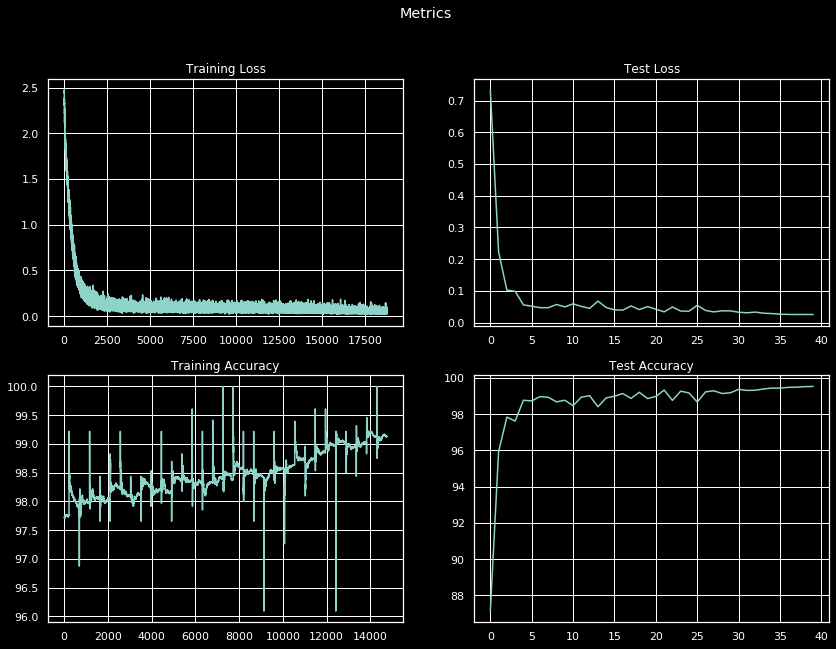

In [17]:
plot_metrics(train_metric, test_metric)

## Plot Misclassifications

Total Misclassifications : 48


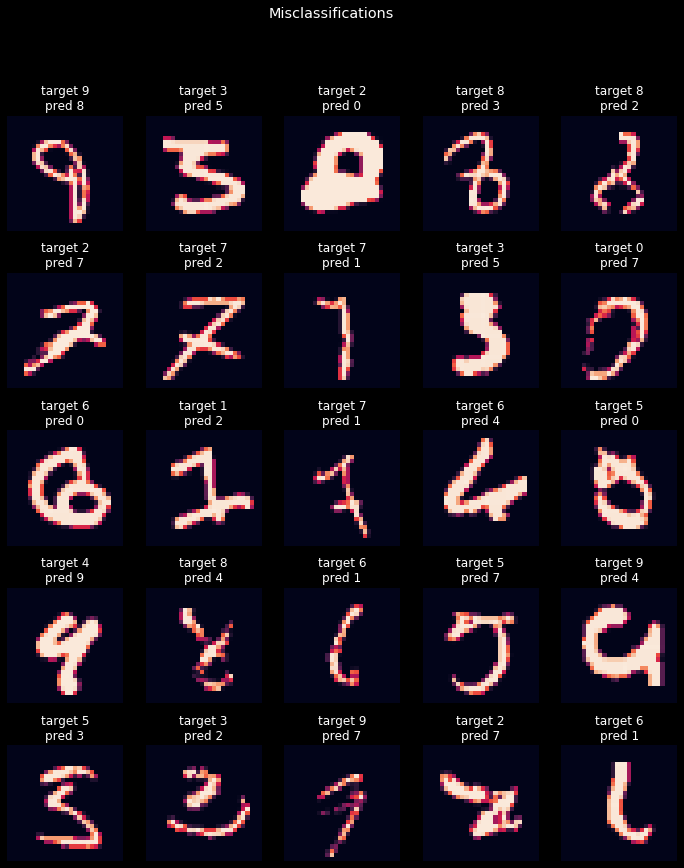

In [18]:
misclassified = trainer.get_misclassified()
plot_misclassification(misclassified)

# With L1 and L2

In [19]:
experiment_name = 'l1_l2'

# move the model to device
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=5e-3)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# create our Trainer object
trainer = Trainer(model, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)

# train and test the model
train_metric, test_metric, lr_values = trainer.train(n_epoch=EPOCHS, l1_lambda=5e-4, l2_lambda=5e-3)

# save the metrics
metric_values[experiment_name] = copy.deepcopy((train_metric, test_metric))

# save the model
models[experiment_name] = copy.deepcopy(model)
torch.save(model, './{}'.format(experiment_name))

Training the model for 40 epochs
EPOCH: 1 LR: [0.0003999999999999993]




Test set: Average loss: 0.7850, Accuracy: 8450/10000 (84.50%)

EPOCH: 2 LR: [0.000563613839009016]




Test set: Average loss: 0.3691, Accuracy: 9133/10000 (91.33%)

EPOCH: 3 LR: [0.0010433014025713703]




Test set: Average loss: 0.1685, Accuracy: 9700/10000 (97.00%)

EPOCH: 4 LR: [0.0018063612224373474]




Test set: Average loss: 0.2000, Accuracy: 9552/10000 (95.52%)

EPOCH: 5 LR: [0.0028007736542228637]




Test set: Average loss: 0.2484, Accuracy: 9296/10000 (92.96%)

EPOCH: 6 LR: [0.003958747183126785]




Test set: Average loss: 0.2467, Accuracy: 9305/10000 (93.05%)

EPOCH: 7 LR: [0.005201339936426282]




Test set: Average loss: 0.2201, Accuracy: 9451/10000 (94.51%)

EPOCH: 8 LR: [0.0064438413429996405]




Test set: Average loss: 0.3202, Accuracy: 9138/10000 (91.38%)

EPOCH: 9 LR: [0.007601547059053706]




Test set: Average loss: 0.5229, Accuracy: 8228/10000 (82.28%)

EPOCH: 10 LR: [0.008595533469319192]




Test set: Average loss: 0.2571, Accuracy: 9216/10000 (92.16%)

EPOCH: 11 LR: [0.009358038101918462]




Test set: Average loss: 0.3091, Accuracy: 9112/10000 (91.12%)

EPOCH: 12 LR: [0.009837079160934131]




Test set: Average loss: 0.3364, Accuracy: 8934/10000 (89.34%)

EPOCH: 13 LR: [0.009999999856920877]




Test set: Average loss: 0.2130, Accuracy: 9492/10000 (94.92%)

EPOCH: 14 LR: [0.009968427106235795]




Test set: Average loss: 0.2812, Accuracy: 9319/10000 (93.19%)

EPOCH: 15 LR: [0.009874373753452848]




Test set: Average loss: 0.2729, Accuracy: 9306/10000 (93.06%)

EPOCH: 16 LR: [0.009719022574054307]




Test set: Average loss: 0.3145, Accuracy: 9323/10000 (93.23%)

EPOCH: 17 LR: [0.00950432719925796]




Test set: Average loss: 0.7035, Accuracy: 7676/10000 (76.76%)

EPOCH: 18 LR: [0.009232987547971035]




Test set: Average loss: 0.4133, Accuracy: 8855/10000 (88.55%)

EPOCH: 19 LR: [0.008908415873743395]




Test set: Average loss: 0.6587, Accuracy: 7902/10000 (79.02%)

EPOCH: 20 LR: [0.008534693853699324]




Test set: Average loss: 0.4972, Accuracy: 8449/10000 (84.49%)

EPOCH: 21 LR: [0.008116521259079443]




Test set: Average loss: 0.3221, Accuracy: 8868/10000 (88.68%)

EPOCH: 22 LR: [0.00765915685289049]




Test set: Average loss: 0.2998, Accuracy: 9189/10000 (91.89%)

EPOCH: 23 LR: [0.0071683522579092974]




Test set: Average loss: 0.2311, Accuracy: 9411/10000 (94.11%)

EPOCH: 24 LR: [0.006650279626689217]




Test set: Average loss: 0.3481, Accuracy: 8972/10000 (89.72%)

EPOCH: 25 LR: [0.00611145402316058]




Test set: Average loss: 0.2717, Accuracy: 9231/10000 (92.31%)

EPOCH: 26 LR: [0.0055586514919216574]




Test set: Average loss: 0.3012, Accuracy: 9037/10000 (90.37%)

EPOCH: 27 LR: [0.004998823845546279]




Test set: Average loss: 0.4199, Accuracy: 8648/10000 (86.48%)

EPOCH: 28 LR: [0.004439011241507181]




Test set: Average loss: 0.5847, Accuracy: 8191/10000 (81.91%)

EPOCH: 29 LR: [0.0038862536481109942]




Test set: Average loss: 0.5155, Accuracy: 8459/10000 (84.59%)

EPOCH: 30 LR: [0.003347502312812102]




Test set: Average loss: 0.2154, Accuracy: 9469/10000 (94.69%)

EPOCH: 31 LR: [0.0028295323462426913]




Test set: Average loss: 0.1446, Accuracy: 9727/10000 (97.27%)

EPOCH: 32 LR: [0.0023388575212655504]




Test set: Average loss: 0.1490, Accuracy: 9646/10000 (96.46%)

EPOCH: 33 LR: [0.00188164835850093]




Test set: Average loss: 0.1097, Accuracy: 9782/10000 (97.82%)

EPOCH: 34 LR: [0.0014636545284495313]




Test set: Average loss: 0.1432, Accuracy: 9718/10000 (97.18%)

EPOCH: 35 LR: [0.0010901325460499196]




Test set: Average loss: 0.1081, Accuracy: 9738/10000 (97.38%)

EPOCH: 36 LR: [0.0007657796669532728]




Test set: Average loss: 0.1480, Accuracy: 9710/10000 (97.10%)

EPOCH: 37 LR: [0.0004946748168081546]




Test set: Average loss: 0.1174, Accuracy: 9754/10000 (97.54%)

EPOCH: 38 LR: [0.00028022729640383835]




Test set: Average loss: 0.1083, Accuracy: 9797/10000 (97.97%)

EPOCH: 39 LR: [0.0001251339077347576]




Test set: Average loss: 0.0819, Accuracy: 9866/10000 (98.66%)

EPOCH: 40 LR: [3.1345040150706035e-05]




Test set: Average loss: 0.0809, Accuracy: 9876/10000 (98.76%)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Plot Metrics

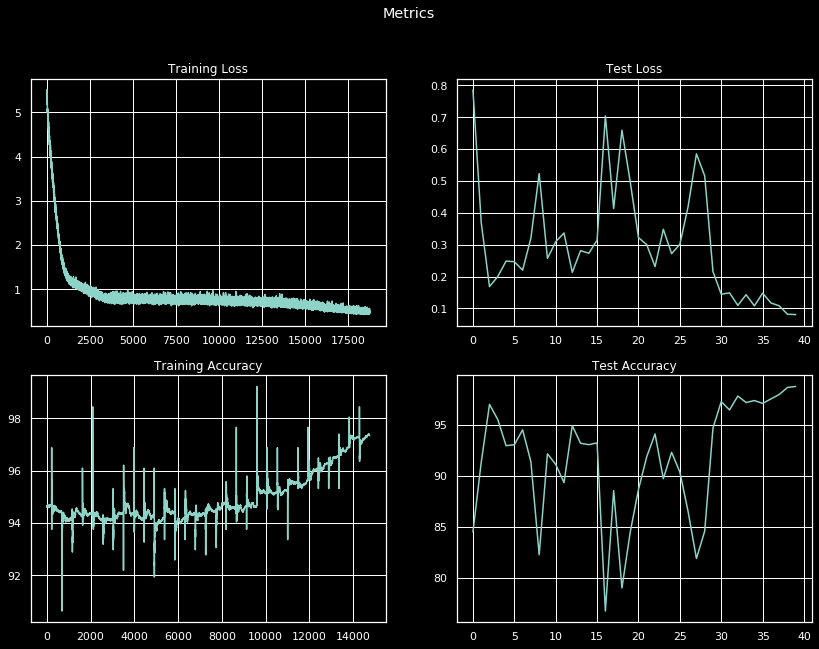

In [20]:
plot_metrics(train_metric, test_metric)

## Plot Misclassifications

Total Misclassifications : 124


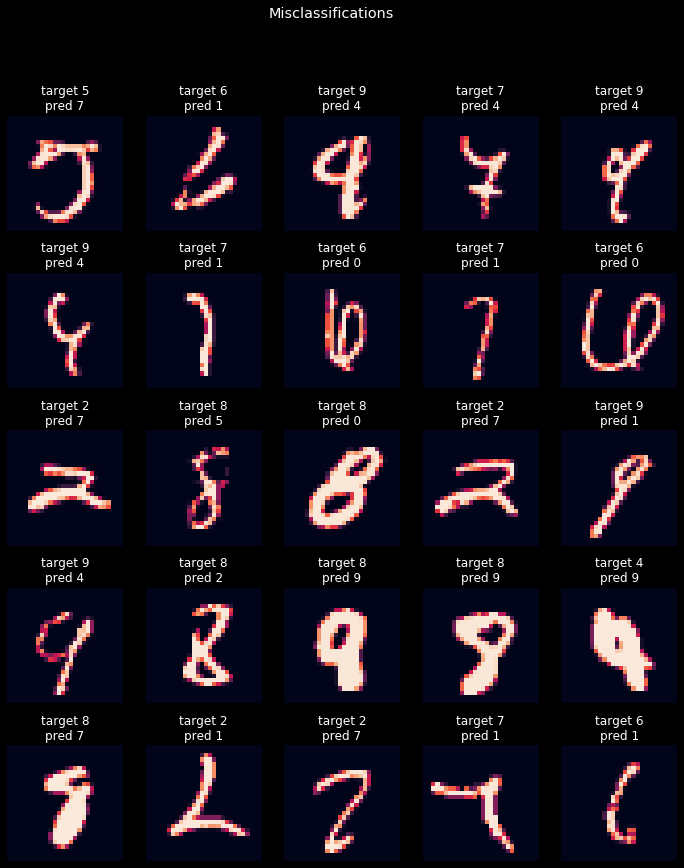

In [21]:
misclassified = trainer.get_misclassified()
plot_misclassification(misclassified)

# Compare all the Models

## Validation Accuracy Plots

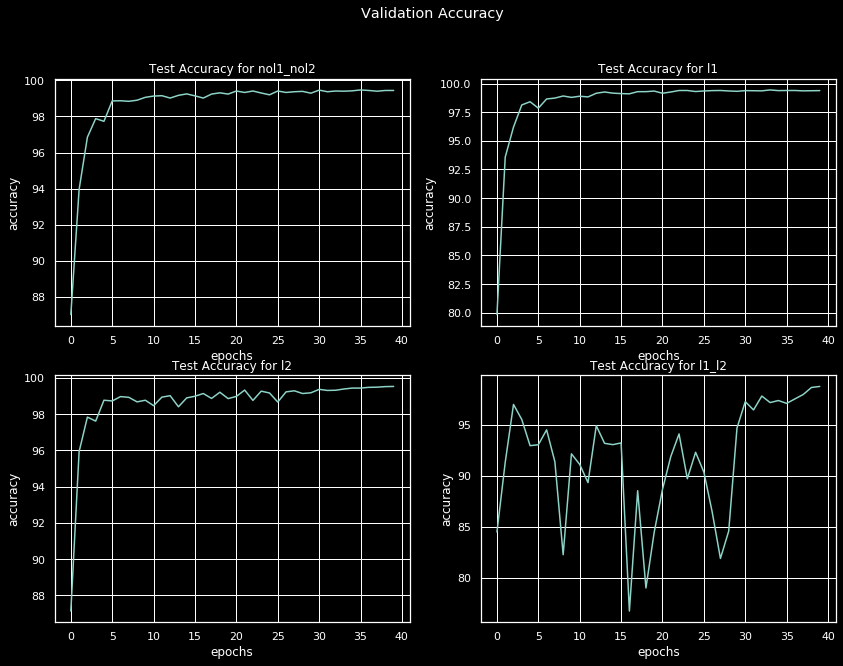

In [22]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Validation Accuracy')
for idx, exp_name in enumerate(metric_values.keys()):
    train_metric, test_metric = metric_values[exp_name]
    test_acc, test_loss = test_metric
    axs = fig.add_subplot(2, 2, idx+1)
    axs.plot(test_acc)
    axs.set_title("Test Accuracy for {}".format(exp_name))
    axs.set_xlabel('epochs')
    axs.set_ylabel('accuracy')
plt.show()

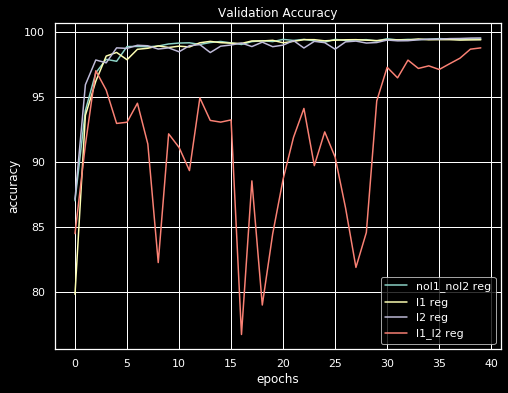

In [23]:
plt.figure(figsize=(8, 6))
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
for idx, exp_name in enumerate(metric_values.keys()):
    train_metric, test_metric = metric_values[exp_name]
    test_acc, test_loss = test_metric
    plt.plot(test_acc, label='{} reg'.format(exp_name))
plt.legend()
plt.show()

## Validation Loss Plots

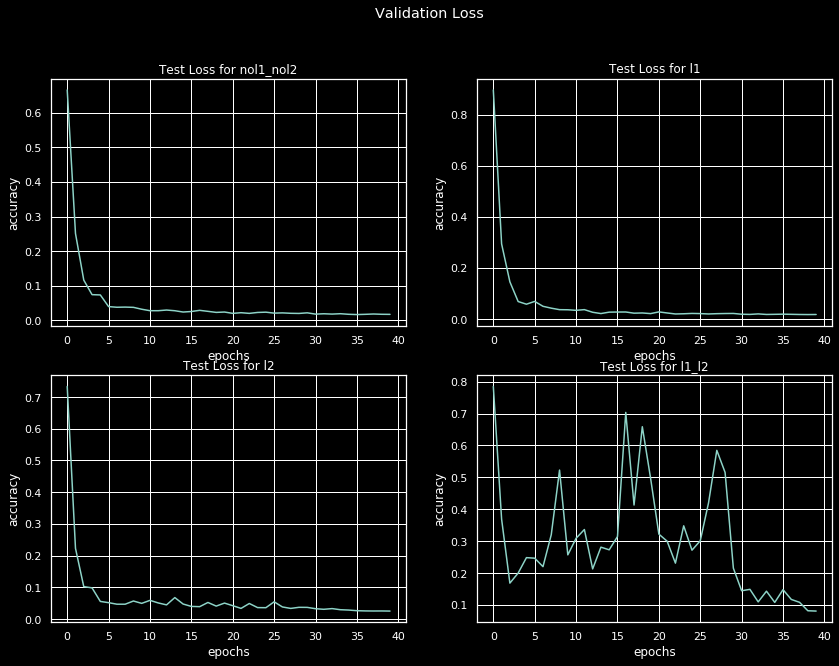

In [24]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Validation Loss')
for idx, exp_name in enumerate(metric_values.keys()):
    train_metric, test_metric = metric_values[exp_name]
    test_acc, test_loss = test_metric
    axs = fig.add_subplot(2, 2, idx+1)
    axs.plot(test_loss)
    axs.set_title("Test Loss for {}".format(exp_name))
    axs.set_xlabel('epochs')
    axs.set_ylabel('loss')
plt.show()

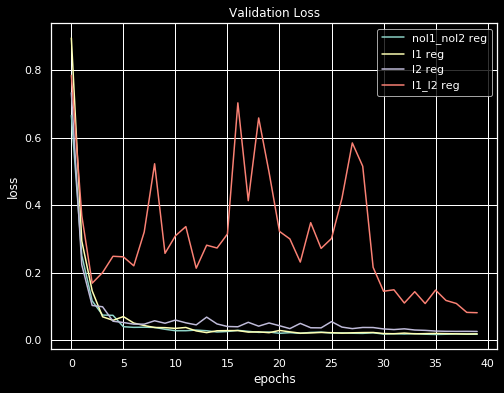

In [26]:
plt.figure(figsize=(8, 6))
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
for idx, exp_name in enumerate(metric_values.keys()):
    train_metric, test_metric = metric_values[exp_name]
    test_acc, test_loss = test_metric
    plt.plot(test_loss, label='{} reg'.format(exp_name))
plt.legend()
plt.show()